In [39]:
import json
import random
import matplotlib.pyplot as plt
import datetime

def get_date(day_of_year, year):
    # Create a datetime object for January 1st of the given year
    base_date = datetime.datetime(year, 1, 1)
    
    # Add the number of days to the base date to get the target date
    target_date = base_date + datetime.timedelta(days=day_of_year - 1)
    
    # Format the date as "{Month} {Day}, {Year}"
    formatted_date = target_date.strftime("%B %d, %Y")
    
    return formatted_date

def calculate_bias(data, historical_temps, weight_prev_year):
    # Calculate the bias from current data and historical data
    # Uses a weighted rolling bias that decreases linearly beyond extrapolation date
    # Rolling bias is weighted relative to the yearly average bias
    filtered_data = list(filter(lambda item: item is not None, data))
    # this includes la nina years so it isn't very good (need to fix)
    bias = [None] * 366
    bias_rolling = 0
    bias_total = 0
    bias_count = 0
    bias_avg = 0
    # only bias against recent era
    for i in range(0, len(historical_temps)):
        filtered_historical = list(filter(lambda item: item is not None, historical_temps[i]))
        historical_avg = sum(filtered_historical) / len(filtered_historical)
        if data[i]:
            bias_rolling = data[i] - historical_avg
            bias[i] = bias_rolling
            bias_total += bias_rolling
            bias_count += 1
        else:
            bias_prev_year = filtered_historical[len(filtered_historical) - 1] - historical_avg
            bias_avg = bias_total / bias_count
            extended = i - bias_count + 1
            days_left = 366 - extended
            # dumb interpolation for bias
            # decrease the weight of the rolling bias linearly in time against the bias_avg for this year so far
            weight = (days_left - extended) / days_left
            bias[i] = (weight * bias_rolling) + ((1 - weight) * (1 - weight_prev_year) * bias_avg) + ((1 - weight) * weight_prev_year * bias_prev_year)
    return bias

def run_extrapolation(extrapolate_year, weight_prev_year, last_day, n, filepath, graph):
    # Step 1: Load and parse the JSON file
    with open(filepath) as file:
        data = json.load(file)

    # Step 2: Filter the data to include only four-digit years
    filtered_data = [entry for entry in data if len(entry['name']) == 4]

    # Step 3: Separate historical data and partially filled in data from extrapolate_year
    historical_data = [entry for entry in filtered_data if int(entry['name']) < extrapolate_year]
    partial_data = [entry for entry in filtered_data if int(entry['name']) == extrapolate_year]

    # Step 4: Extract historical temperatures for each day
    historical_temps = [[] for _ in range(366)]  # Assuming 365 days in a year, no leap years
    for entry in historical_data:
        for i, temp in enumerate(entry['data']):
            historical_temps[i].append(temp)

    # Step 5: Monte Carlo simulations to fill in missing data for projected year
    bias = [None] * 366
    simulated_data_adj = []
    max_obs_temp = 0
    start_index = 0
    for entry in partial_data:
        filtered_data = list(filter(lambda item: item is not None, entry['data']))
        max_obs_temp = max(filtered_data)
        num_missing_values = entry['data'].count(None)
        simulated_temps_adj = [None] * 366
        start_index = entry['data'].index(None)  # Index where missing data starts

        bias = calculate_bias(entry['data'], historical_temps, weight_prev_year)
        for i in range(start_index, start_index + num_missing_values):
            count = 0
            simulated_total = 0
            while count < n:
                c = random.choice(historical_temps[i])
                if c:
                    if bias[i]:
                        simulated_total += c + bias[i]
                    else:
                        simulated_total += c
                    count += 1
            simulated_temps_adj[i] = simulated_total / n
        simulated_data_adj.append({'name': entry['name'], 'data': simulated_temps_adj})

    if graph:
        # code for looking at graphs and printing out all temps
        print(f"Observed maximum: {max_obs_temp}")
        print(f"Possible days of observed maximum being exceeded:")
        print(f"Projected days where observed maximum is surpassed:")
        for i in range(start_index, 366):
            temp = simulated_data_adj[0]['data'][i]
            if temp > max_obs_temp:
                formatted_date = get_date(i + 1, extrapolate_year)
                count += 1
                temp_str = str(round(temp, 3))
                print(f"{formatted_date}: {temp_str}")
    else:
        # count record breaking days up to last_day
        count = 0
        for i in range(start_index, last_day):
            temp = simulated_data_adj[0]['data'][i]
            if temp > max_obs_temp:
                #formatted_date = get_date(i + 1, extrapolate_year)
                count += 1
                #temp_str = str(round(temp, 3))
                #print(f"{formatted_date}: {temp_str}")
        return count

    # Step 6: Create a graph with simulated temperature data for projected year
    x = range(1, len(partial_data[0]['data']) + 1)
    y = partial_data[0]['data']
    fig, ax = plt.subplots()
    lbl = 'Observed ' + str(extrapolate_year) + ' Data'
    ax.plot(x, y, label=lbl)
    # use commented plots to examine the biases
    ax.plot(x, simulated_data_adj[0]['data'], label='Simulated Data with Adjusted Bias')

    ax.set_xlabel('Day')
    ax.set_ylabel('Temperature')
    lbl = 'Simulated Temperature Data for ' + str(extrapolate_year)
    ax.set_title(lbl)
    ax.legend()
    plt.show()

In [14]:
#### CONFIG FOR MAIN PARAMETERS
# number of simulations to average
n = 1000
# current year want to extrapolate data for that already have partial data
extrapolate_year = 2023
# also weight for previous year against bias avg for this year
# in other words, how large will the bias at the end of this year be from the avg bias calculated of this year so far from the historical average
# use a range of them to get a better idea
weights_prev_year = [0.001, 0.01, 0.1, 0.2, 0.4, 0.8, 0.16, 0.32, 0.64, 0.99]
# file path to local copy of json wih temp data
# from https://climatereanalyzer.org/clim/t2_daily/json/cfsr_world_t2_day.json
filepath = 'cfsr_world_t2_day.json'

In [21]:
# CONFIG FOR SPECIFIC RUN
# last day of year of range to check record for (July 12)
last_day = 193

graph = False
formatted_date = get_date(last_day, extrapolate_year)
print(f"Projected # days where current record is broken {formatted_date} :")
repeats = int(n / 10)
print("========================================================")
print("Prev year weight: # days where current max temp record is broken")
for weight_prev_year in weights_prev_year:
    total = 0
    for i in range(0, repeats):
        total += run_extrapolation(extrapolate_year, weight_prev_year, last_day, n, filepath, graph)
    avg = total / repeats
    print(f"{weight_prev_year}: {avg}")

Projected # days where current record is broken July 12, 2023 :
Prev year weight: # days where current max temp record is broken
0.001: 0.07
0.01: 0.05
0.1: 0.06
0.2: 0.05
0.4: 0.03
0.8: 0.01
0.16: 0.03
0.32: 0.05
0.64: 0.03
0.99: 0.03


In [22]:
# CONFIG FOR SPECIFIC RUN
# last day of year of range to check record for (July 31)
last_day = 212

graph = False
formatted_date = get_date(last_day, extrapolate_year)
print(f"Projected # days where current record is broken {formatted_date} :")
repeats = int(n / 10)
print("========================================================")
print("Prev year weight: # days where current max temp record is broken")
for weight_prev_year in [0.001, 0.005, 0.01, 0.02, 0.04, 0.8, 0.16, 0.32, 0.64, 0.99]:
    total = 0
    for i in range(0, repeats):
        total += run_extrapolation(extrapolate_year, weight_prev_year, last_day, n, filepath, graph)
    avg = total / repeats
    print(f"{weight_prev_year}: {avg}")

Projected # days where current record is broken July 31, 2023 :
Prev year weight: # days where current max temp record is broken
0.001: 13.7
0.005: 13.99
0.01: 13.79
0.02: 13.83
0.04: 13.81
0.8: 13.96
0.16: 13.74
0.32: 13.67
0.64: 13.87
0.99: 13.94


Observed maximum: 17.233
Possible days of observed maximum being exceeded:
Projected days where observed maximum is surpassed:
July 14, 2023: 17.248
July 15, 2023: 17.25
July 16, 2023: 17.249
July 17, 2023: 17.254
July 18, 2023: 17.241
July 19, 2023: 17.243
July 20, 2023: 17.252
July 21, 2023: 17.235
July 26, 2023: 17.235
July 27, 2023: 17.236
July 28, 2023: 17.24
July 29, 2023: 17.245
July 30, 2023: 17.236
August 01, 2023: 17.247
August 02, 2023: 17.242


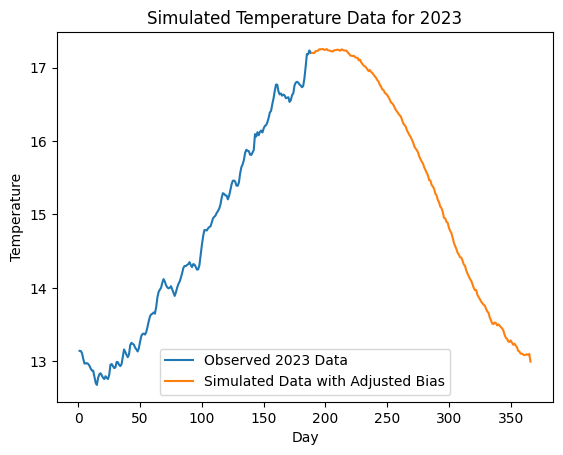

In [44]:
# Graph and show extrapolations for a single run
# this is arbitrarily chosen
weight_prev_year = 0.2
graph = True
run_extrapolation(extrapolate_year, weight_prev_year, last_day, n, filepath, graph)